<img src='images/pic1.jpg'/>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install scikit-multilearn


     |████████████████████████████████| 92kB 3.1MB/s 


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime


# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [0]:
#Creating db file from csv
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('gdrive/My Drive/Colab Notebooks/Train.csv',nrows=200000, names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:18.113470


<h3> 3.1.2 Counting the number of rows </h3>

In [0]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 200000
Time taken to count the number of rows : 0:00:00.009961


<h3>3.1.3 Checking for duplicates </h3>

In [0]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:00:02.063599


In [0]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1
1,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1
2,Controlling the Lego WeDo Device,<p>Has anyone written a API for the Lego WeDo ...,c# api lego,1
3,Dialog not getting recreated on orientation c...,<p>called using:</p>\n\n<p>showDialog(DIALOG_L...,android dialog display orientation,1
4,Dynamically changing localization in VS2010 s...,<p>I would like to know how to change localiza...,c# visual-studio-2010 localization,1


In [0]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 2250 ( 1.1249999999999982 % )


In [0]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    195507
2      2236
3         7
Name: cnt_dup, dtype: int64

In [0]:
df_no_dup['Tags']=df_no_dup['Tags'].apply(str)

In [0]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.151672


,Title,Body,Tags,cnt_dup,tag_count
0,*** Exception: Prelude.read: no parse in Hask...,<p>This portion of code should read in two or ...,parsing haskell expression,1,3
1,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1,2
2,Controlling the Lego WeDo Device,<p>Has anyone written a API for the Lego WeDo ...,c# api lego,1,3
3,Dialog not getting recreated on orientation c...,<p>called using:</p>\n\n<p>showDialog(DIALOG_L...,android dialog display orientation,1,4
4,Dynamically changing localization in VS2010 s...,<p>I would like to know how to change localiza...,c# visual-studio-2010 localization,1,3


In [0]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    56635
2    52585
4    37959
1    27163
5    23408
Name: tag_count, dtype: int64

In [0]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [0]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:00.309526


<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [0]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [0]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 197749
Number of unique tags : 23686


In [0]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.doc', '.each', '.emf', '.hgtags', '.htaccess']


<h3> 3.2.3 Number of times a tag appeared </h3>

In [0]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [0]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,3
1,.app,1
2,.aspxauth,1
3,.bash-profile,3
4,.class-file,2


In [0]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

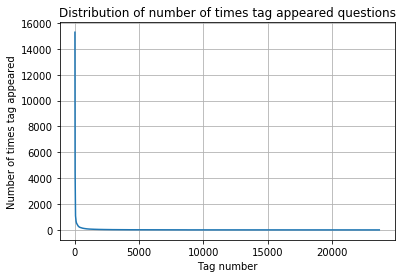

In [0]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

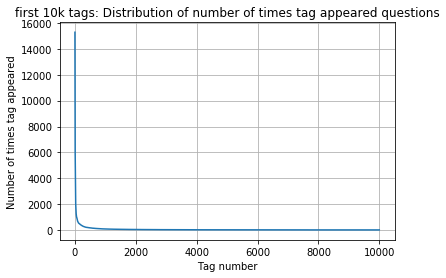

400 [15289  1995  1056   830   625   523   482   427   380   345   313   276
   255   233   217   204   196   189   179   171   164   157   149   140
   135   131   125   121   115   112   107   104    99    97    94    89
    86    84    82    79    77    75    73    71    69    67    66    64
    63    61    60    59    58    57    56    55    54    53    52    51
    49    48    48    47    46    45    45    44    43    43    42    41
    40    40    39    39    38    37    37    36    36    35    35    34
    34    34    33    32    32    31    31    31    30    30    30    29
    29    28    28    28    27    27    26    26    26    25    25    25
    24    24    24    24    23    23    23    22    22    22    22    21
    21    21    21    21    20    20    20    20    20    19    19    19
    19    19    19    18    18    18    18    18    18    17    17    17
    17    17    17    16    16    16    16    16    16    16    15    15
    15    15    15    15    15    15    14    1

In [0]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

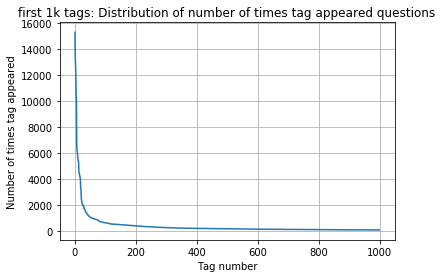

200 [15289  9803  5517  4334  3165  1995  1718  1450  1293  1153  1056  1003
   961   907   887   830   742   702   668   645   625   602   584   549
   530   523   512   508   500   490   482   467   455   444   438   427
   419   412   397   389   380   371   367   357   351   345   332   327
   323   318   313   304   296   290   283   276   272   267   264   260
   255   248   244   239   237   233   231   228   222   220   217   216
   210   209   206   204   202   200   199   197   196   194   193   193
   190   189   186   185   183   182   179   177   176   175   173   171
   169   167   166   164   164   162   162   160   158   157   154   153
   152   151   149   148   146   144   142   140   139   137   137   136
   135   134   133   133   132   131   130   129   127   126   125   124
   124   123   122   121   121   118   117   116   115   115   114   113
   112   112   111   110   109   109   107   107   106   106   105   104
   103   102   100   100    99    99    99    9

In [0]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

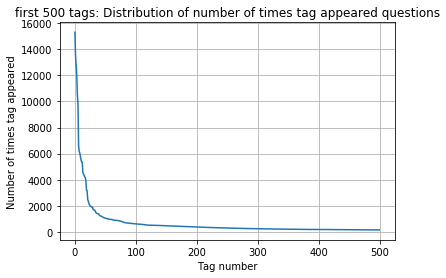

100 [15289  9803  5517  4334  3165  1995  1718  1450  1293  1153  1056  1003
   961   907   887   830   742   702   668   645   625   602   584   549
   530   523   512   508   500   490   482   467   455   444   438   427
   419   412   397   389   380   371   367   357   351   345   332   327
   323   318   313   304   296   290   283   276   272   267   264   260
   255   248   244   239   237   233   231   228   222   220   217   216
   210   209   206   204   202   200   199   197   196   194   193   193
   190   189   186   185   183   182   179   177   176   175   173   171
   169   167   166   164]


In [0]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

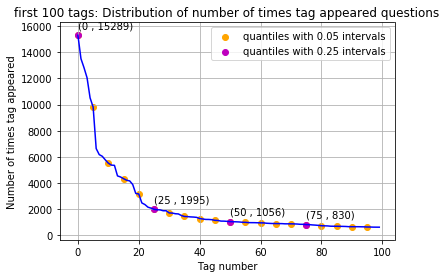

20 [15289  9803  5517  4334  3165  1995  1718  1450  1293  1153  1056  1003
   961   907   887   830   742   702   668   645]


In [0]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [0]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

5 Tags are used more than 10000 times
0 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.2.4 Tags Per Question </h3>

In [0]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 197749 datapoints.
[2, 3, 4, 3, 4]


In [0]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.888060


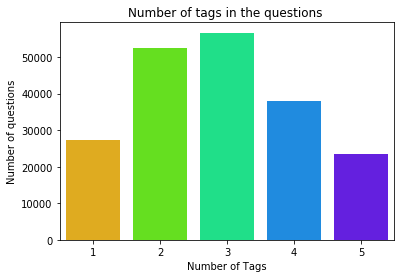

In [0]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

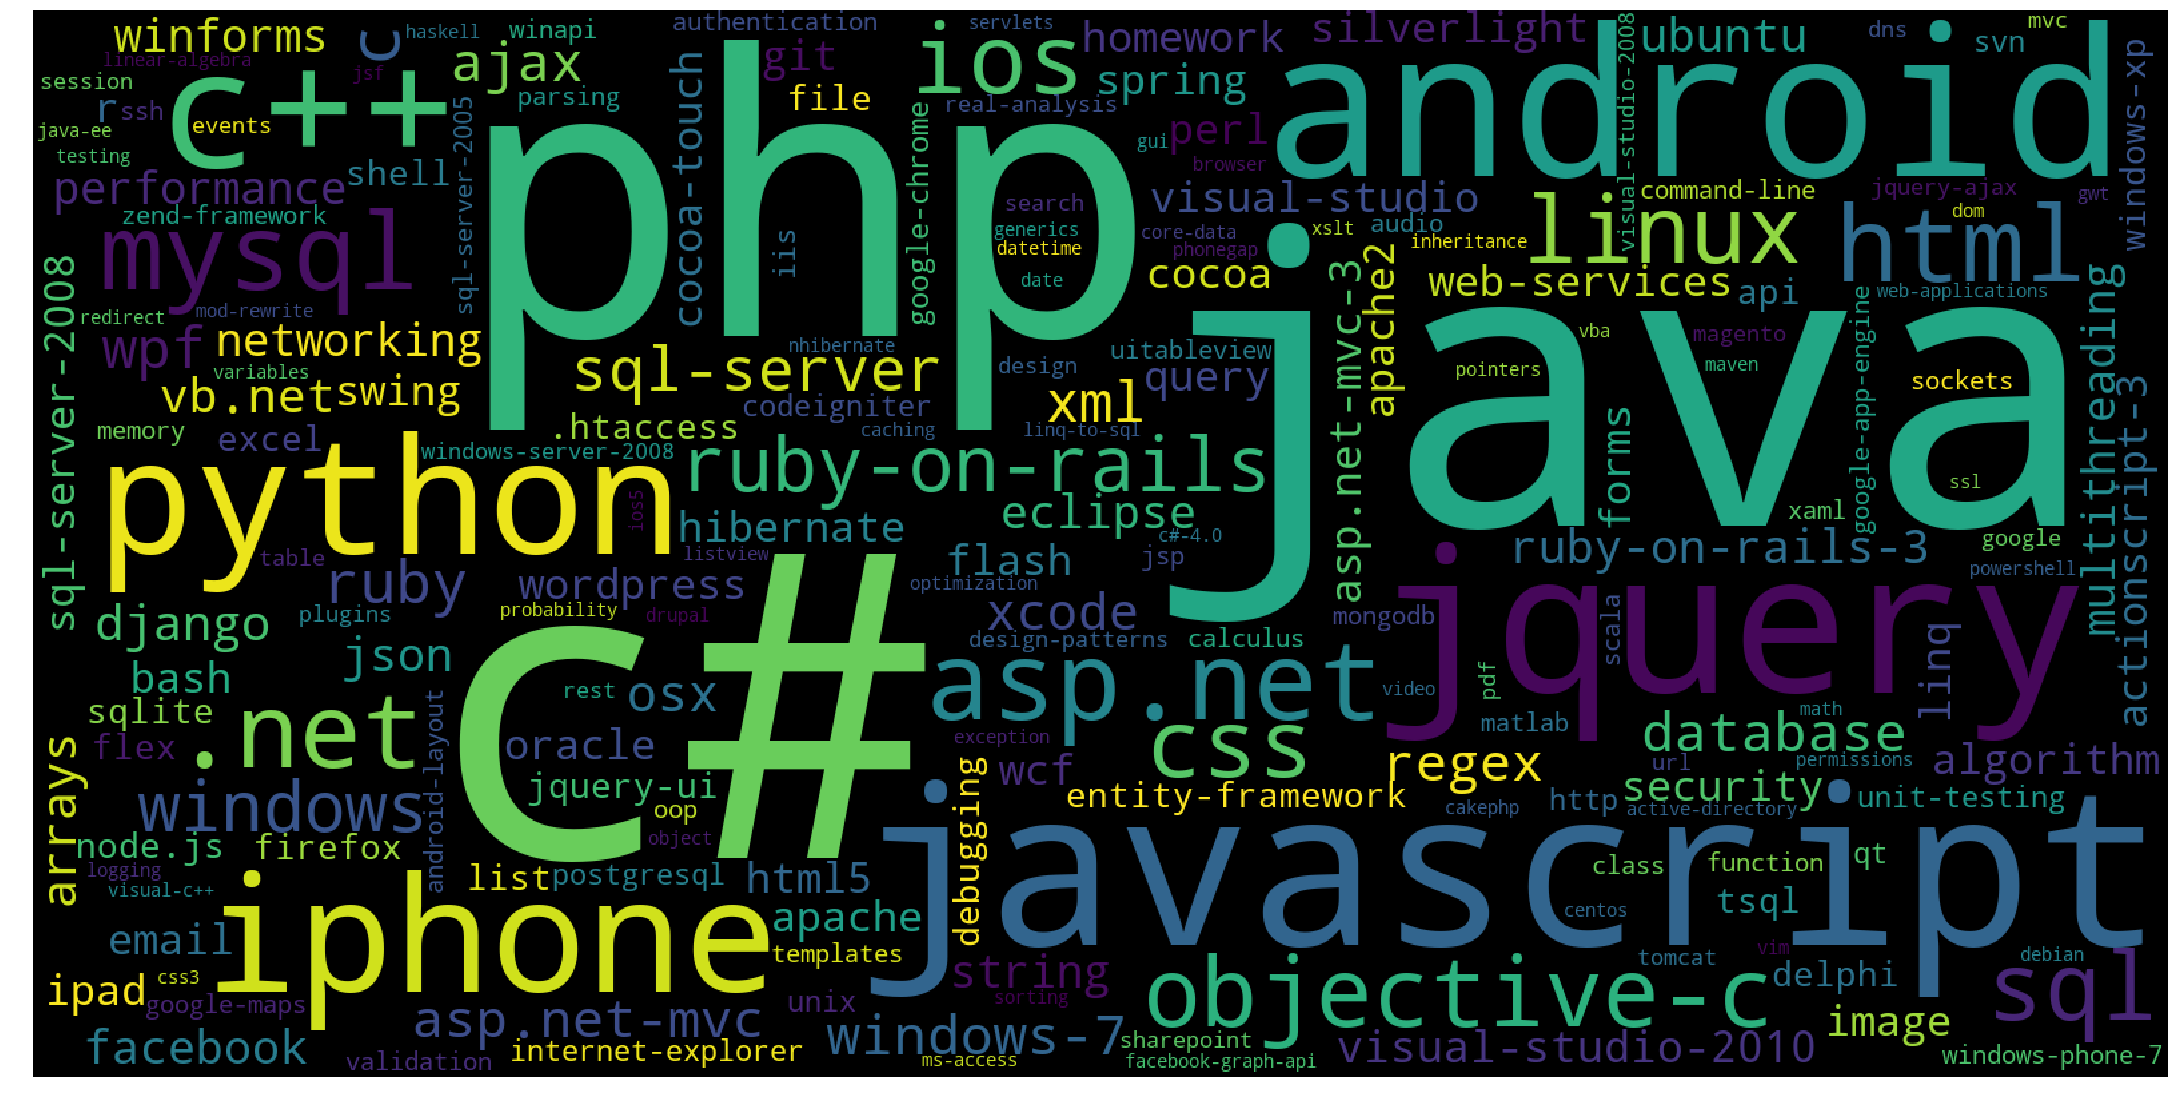

Time taken to run this cell : 0:00:05.572168


In [0]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 3.2.6 The top 20 tags </h3>

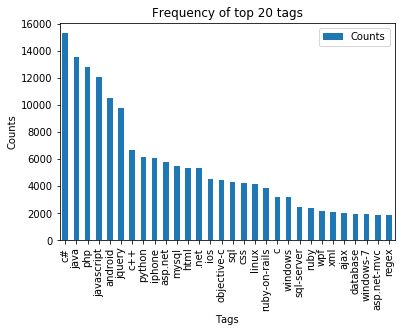

In [0]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
 
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [0]:
import nltk
nltk.download('stopwords')
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 300000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:00:08.790824


__ we create a new data base to store the sampled and preprocessed questions __

In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
import nltk
nltk.download('punkt')
  
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Avg. length of questions(Title+Body) before processing: 1151
Avg. length of questions(Title+Body) after processing: 328
Percent of questions containing code: 56
Time taken to run this cell : 0:05:10.829583


In [0]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [0]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('media player error decreas seek bar volum decreas progress increas increas volum real state problem media player audiomanag decreas volum sound seekbar decreas progress increas increas sound volum state pleas help sort problem nthank advanc',)
----------------------------------------------------------------------------------------------------
('mount amazon bucket directori freebsd find solut mount amazon bucket exist directori freebsd ni suspect need instal port configur find info',)
----------------------------------------------------------------------------------------------------
('unit test updatemodel method within mvc updat recent modifi view post control json object rather formcollect order get unit test control work set formvalu provid dictionari object stop updatemodel method throw nre result unit test howev simpli feel like right thing insight rework would great appreci thank advanc',)
-----------------------------------------------------------

In [0]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
preprocessed_data.head()

,question,tags
0,string also static string creation within meth...,java string
1,media player error decreas seek bar volum decr...,android mediaplayer android-audiomanager
2,mount amazon bucket directori freebsd find sol...,mount freebsd amazon-s3
3,unit test updatemodel method within mvc updat ...,asp.net-mvc unit-testing asp.net-mvc-3
4,problem macport pick wrong python previous ins...,python osx macports


In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 197749
number of dimensions : 2


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [0]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

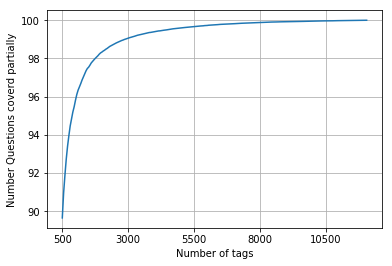

with  5500 tags we are covering  99.062 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [0]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 1855 out of  197749


In [0]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 23686
number of tags taken : 5500 ( 23.220467786878324 %)


__ We consider top 15% tags which covers  99% of the questions __

<h2>4.2 Split the data into test and train (80:20) </h2>

In [0]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (158199, 5500)
Number of data points in test data : (39550, 5500)


<h2>4.3 Featurizing data </h2>

In [0]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_tfidf_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_tfidf_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:44.519934


In [0]:
print("Dimensions of train data X:",x_tfidf_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_tfidf_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (158199, 88660) Y : (158199, 5500)
Dimensions of test data X: (39550, 88660) Y: (39550, 5500)


In [0]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://stats.stackexchange.com/questions/117796/scikit-multi-label-classification
# classifier = LabelPowerset(GaussianNB())
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))

"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
#MemoryError                               Traceback (most recent call last)
#<ipython-input-170-f0e7c7f3e0be> in <module>()
#----> classifier.fit(x_train_multilabel, y_train)

"\nfrom skmultilearn.adapt import MLkNN\nclassifier = MLkNN(k=21)\n\n# train\nclassifier.fit(x_train_multilabel, y_train)\n\n# predict\npredictions = classifier.predict(x_test_multilabel)\nprint(accuracy_score(y_test,predictions))\nprint(metrics.f1_score(y_test, predictions, average = 'macro'))\nprint(metrics.f1_score(y_test, predictions, average = 'micro'))\nprint(metrics.hamming_loss(y_test,predictions))\n\n"

<h2> 4.5 Modeling with less data points (0.1M data points) and more weight to title and 500 tags only. </h2>



In [0]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [0]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 60000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 80000;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


<h3> 4.5.1 Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [0]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

Avg. length of questions(Title+Body) before processing: 1130
Avg. length of questions(Title+Body) after processing: 411
Percent of questions containing code: 54
Time taken to run this cell : 0:02:57.503441


In [0]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

In [0]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('control lego wedo devic control lego wedo devic control lego wedo devic anyon written api lego wedo devic c found python api hope someon done .net https github.com itdanih wedomor tri write use libusb c know much usb python thank',)
----------------------------------------------------------------------------------------------------
('dialog get recreat orient chang dialog get recreat orient chang dialog get recreat orient chang call use showdialog dialog long click menu id problem leak window orient chang activ get re-creat never call oncreatedialog onpreparedialog know make differ activ within tab insight possibl caus massiv appreci',)
----------------------------------------------------------------------------------------------------
('dynam chang local vs2010 setup project dynam chang local vs2010 setup project dynam chang local vs2010 setup project would like know chang local vs2008 setup project dynam scenario like oper system langaug french user cli

__ Saving Preprocessed data to a Database __

In [0]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [0]:
preprocessed_data.head()

,question,tags
0,access local session bean expos resteasi inter...,ejb resteasy
1,control lego wedo devic control lego wedo devi...,c# api lego
2,dialog get recreat orient chang dialog get rec...,android dialog display orientation
3,dynam chang local vs2010 setup project dynam c...,c# visual-studio-2010 localization
4,encod sent data work encod sent data work enco...,php jquery ajax encoding


In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 79999
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

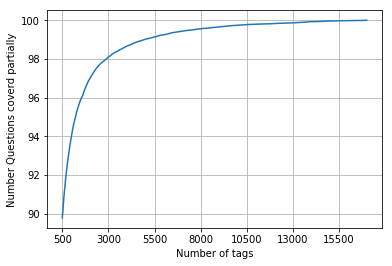

with  5500 tags we are covering  99.136 % of questions
with  500 tags we are covering  89.772 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 8182 out of  79999


In [0]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 60000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (60000, 500)
Number of data points in test data : (19999, 500)


<h3> 4.5.2 Featurizing data with BOW vectorizer </h3>

In [0]:
start = datetime.now()
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000,ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:44.179529


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (60000, 99490) Y : (60000, 500)
Dimensions of test data X: (19999, 99490) Y: (19999, 500)


In [0]:
x_train_multilabel.shape

(60000, 99490)

<h3> 4.5.3 Applying SGD Logistic Regression with OneVsRest Classifier </h3>

In [69]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
start = datetime.now()
parameters={'estimator__alpha': [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}
start = datetime.now()
clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))
gd_clf = GridSearchCV(estimator = clf, param_grid=parameters, cv=None, verbose=10, scoring='f1_micro',n_jobs=-1)
gd_clf.fit(x_train_multilabel, y_train)
best_alpha = gd_clf.best_estimator_.get_params()['estimator__alpha']
print('value of alpha after hyperparameter tuning : ',best_alpha)
print("Time taken to run this cell :", datetime.now() - start)



Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 79.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 95.7min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 114.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 114.8min finished


value of alpha after hyperparameter tuning :  0.001
Time taken to run this cell : 2:05:24.447594


In [70]:
'''import warnings
warnings.filterwarnings("ignore")
start = datetime.now()
train_f1 = []
cv_f1 = []
estimator__alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in estimator__alpha:
    clf = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l1'))
    clf.fit(x_train_multilabel, y_train)
    y_train_pred =  clf.predict_proba(x_train_multilabel)[:,1]
    y_cv_pred =  clf.predict_proba(x_test_multilabel)[:,1]
    train_f1_score=f1_score(y_train,y_train_pred,average='micro')
    train_f1.append(train_f1_score)
    cv_f1_score=f1_score(y_test, y_cv_pred,average='micro')
    cv_f1.append(cv_f1_score)
    print("alpha = ",i ,"\t","cv_f1_score\t:",cv_f1_score, "\t","train_f1_score\t:",train_f1_score)
print("Time taken to run this cell :", datetime.now() - start)
best_alpha = np.argmin(cv_f1)'''


'import warnings\nwarnings.filterwarnings("ignore")\nstart = datetime.now()\ntrain_f1 = []\ncv_f1 = []\nestimator__alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]\nfor i in estimator__alpha:\n    clf = OneVsRestClassifier(SGDClassifier(loss=\'log\', penalty=\'l1\'))\n    clf.fit(x_train_multilabel, y_train)\n    y_train_pred =  clf.predict_proba(x_train_multilabel)[:,1]\n    y_cv_pred =  clf.predict_proba(x_test_multilabel)[:,1]\n    train_f1_score=f1_score(y_train,y_train_pred,average=\'micro\')\n    train_f1.append(train_f1_score)\n    cv_f1_score=f1_score(y_test, y_cv_pred,average=\'micro\')\n    cv_f1.append(cv_f1_score)\n    print("alpha = ",i ,"\t","cv_f1_score\t:",cv_f1_score, "\t","train_f1_score\t:",train_f1_score)\nprint("Time taken to run this cell :", datetime.now() - start)\nbest_alpha = np.argmin(cv_f1)'

In [71]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=best_alpha, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.1807590379518976
Hamming loss  0.0033051652582629133
Micro-average quality numbers
Precision: 0.5708, Recall: 0.3176, F1-measure: 0.4081
Macro-average quality numbers
Precision: 0.4132, Recall: 0.2529, F1-measure: 0.2931
              precision    recall  f1-score   support

           0       0.41      0.09      0.15      1691
           1       0.85      0.71      0.77      1192
           2       0.78      0.34      0.47      1435
           3       0.77      0.40      0.52      1275
           4       0.74      0.48      0.58      1105
           5       0.78      0.59      0.68       947
           6       0.57      0.16      0.25       621
           7       0.73      0.38      0.50       580
           8       0.42      0.11      0.18       606
           9       0.39      0.25      0.31       585
          10       0.68      0.37      0.48       716
          11       0.84      0.62      0.71       621
          12       0.68      0.48      0.56       417
         

<h3> 4.5.4 Applying Logistic Regression with OneVsRest Classifier </h3>

In [72]:
'''import warnings
warnings.filterwarnings("ignore")
start = datetime.now()
train_f1 = []
cv_f1 = []
C = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in C:
    lg_clf = OneVsRestClassifier(LogisticRegression(class_weight='balanced', penalty='l1'))
    lg_clf.fit(x_train_multilabel, y_train)
    y_train_pred =  lg_clf.predict_proba(x_train_multilabel)[:,1]
    y_cv_pred =  lg_clf.predict_proba(x_test_multilabel)[:,1]
    train_f1_score=f1_score(y_train,y_train_pred,average='micro')
    train_f1.append(train_f1_score)
    cv_f1_score=f1_score(y_test, y_cv_pred,average='micro')
    cv_f1.append(cv_f1_score)
    print("C = ",i ,"\t","cv_f1_score\t:",cv_f1_score, "\t","train_f1_score\t:",train_f1_score)
print("Time taken to run this cell :", datetime.now() - start)
lg_best_alpha = np.argmin(cv_f1)'''


'import warnings\nwarnings.filterwarnings("ignore")\nstart = datetime.now()\ntrain_f1 = []\ncv_f1 = []\nC = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]\nfor i in C:\n    lg_clf = OneVsRestClassifier(LogisticRegression(class_weight=\'balanced\', penalty=\'l1\'))\n    lg_clf.fit(x_train_multilabel, y_train)\n    y_train_pred =  lg_clf.predict_proba(x_train_multilabel)[:,1]\n    y_cv_pred =  lg_clf.predict_proba(x_test_multilabel)[:,1]\n    train_f1_score=f1_score(y_train,y_train_pred,average=\'micro\')\n    train_f1.append(train_f1_score)\n    cv_f1_score=f1_score(y_test, y_cv_pred,average=\'micro\')\n    cv_f1.append(cv_f1_score)\n    print("C = ",i ,"\t","cv_f1_score\t:",cv_f1_score, "\t","train_f1_score\t:",train_f1_score)\nprint("Time taken to run this cell :", datetime.now() - start)\nlg_best_alpha = np.argmin(cv_f1)'

In [73]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
start = datetime.now()
parameters={'estimator__C': [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}
lg_clf = OneVsRestClassifier(LogisticRegression(class_weight='balanced', penalty='l1'))
lg_gd_clf = GridSearchCV(estimator = lg_clf, param_grid=parameters, cv=3, verbose=10, scoring='f1_micro',n_jobs=15)
lg_gd_clf.fit(x_train_multilabel, y_train)
lg_best_alpha = lg_gd_clf.best_estimator_.get_params()['estimator__C']
print('value of alpha after hyperparameter tuning : ',lg_best_alpha)
print("Time taken to run this cell :", datetime.now() - start)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   4 out of  21 | elapsed: 44.5min remaining: 189.3min
[Parallel(n_jobs=15)]: Done   7 out of  21 | elapsed: 144.6min remaining: 289.1min
[Parallel(n_jobs=15)]: Done  10 out of  21 | elapsed: 238.4min remaining: 262.2min
[Parallel(n_jobs=15)]: Done  13 out of  21 | elapsed: 261.0min remaining: 160.6min
[Parallel(n_jobs=15)]: Done  16 out of  21 | elapsed: 272.4min remaining: 85.1min
[Parallel(n_jobs=15)]: Done  19 out of  21 | elapsed: 277.8min remaining: 29.2min
[Parallel(n_jobs=15)]: Done  21 out of  21 | elapsed: 280.6min finished


value of alpha after hyperparameter tuning :  10
Time taken to run this cell : 5:27:56.890444


In [74]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1',C=lg_best_alpha,class_weight='balanced'),n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.14595729786489325
Hamming loss  0.004105705285264263
Micro-average quality numbers
Precision: 0.4322, Recall: 0.4602, F1-measure: 0.4458
Macro-average quality numbers
Precision: 0.3770, Recall: 0.4125, F1-measure: 0.3880
              precision    recall  f1-score   support

           0       0.34      0.38      0.36      1691
           1       0.84      0.79      0.81      1192
           2       0.55      0.52      0.53      1435
           3       0.52      0.54      0.53      1275
           4       0.59      0.58      0.58      1105
           5       0.68      0.65      0.66       947
           6       0.33      0.37      0.35       621
           7       0.48      0.48      0.48       580
           8       0.26      0.25      0.26       606
           9       0.32      0.36      0.34       585
          10       0.55      0.51      0.53       716
          11       0.73      0.67      0.70       621
          12       0.60      0.62      0.61       417
         

<h3> 4.5.5 Applying SGD Linear SVM  with OneVsRest Classifier </h3>

In [75]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
start = datetime.now()
parameters={'estimator__alpha': [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1]}
svm_clf = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))
svm_gd_clf = GridSearchCV(estimator = svm_clf, param_grid=parameters, cv=3, verbose=10, scoring='f1_micro',n_jobs=-1)
svm_gd_clf.fit(x_train_multilabel, y_train)
svm_best_alpha = svm_gd_clf.best_estimator_.get_params()['estimator__alpha']
print('value of alpha after hyperparameter tuning : ',best_alpha)
print("Time taken to run this cell :", datetime.now() - start)


Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 38.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 75.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 95.9min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 125.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 125.4min finished


value of alpha after hyperparameter tuning :  0.001
Time taken to run this cell : 2:14:08.598435


In [76]:
'''import warnings
warnings.filterwarnings("ignore")
start = datetime.now()
train_f1 = []
cv_f1 = []
estimator__alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in estimator__alpha:
    svm_clf = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l1'))
    svm_clf.fit(x_train_multilabel, y_train)
    y_train_pred =  svm_clf.predict_proba(x_train_multilabel)[:,1]
    y_cv_pred =  svm_clf.predict_proba(x_test_multilabel)[:,1]
    train_f1_score=f1_score(y_train,y_train_pred,average='micro')
    train_f1.append(train_f1_score)
    cv_f1_score=f1_score(y_test, y_cv_pred,average='micro')
    cv_f1.append(cv_f1_score)
    print("alpha = ",i ,"\t","cv_f1_score\t:",cv_f1_score, "\t","train_f1_score\t:",train_f1_score)
print("Time taken to run this cell :", datetime.now() - start)
svm_best_alpha = np.argmin(cv_f1)'''


'import warnings\nwarnings.filterwarnings("ignore")\nstart = datetime.now()\ntrain_f1 = []\ncv_f1 = []\nestimator__alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]\nfor i in estimator__alpha:\n    svm_clf = OneVsRestClassifier(SGDClassifier(loss=\'hinge\', penalty=\'l1\'))\n    svm_clf.fit(x_train_multilabel, y_train)\n    y_train_pred =  svm_clf.predict_proba(x_train_multilabel)[:,1]\n    y_cv_pred =  svm_clf.predict_proba(x_test_multilabel)[:,1]\n    train_f1_score=f1_score(y_train,y_train_pred,average=\'micro\')\n    train_f1.append(train_f1_score)\n    cv_f1_score=f1_score(y_test, y_cv_pred,average=\'micro\')\n    cv_f1.append(cv_f1_score)\n    print("alpha = ",i ,"\t","cv_f1_score\t:",cv_f1_score, "\t","train_f1_score\t:",train_f1_score)\nprint("Time taken to run this cell :", datetime.now() - start)\nsvm_best_alpha = np.argmin(cv_f1)'

In [77]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=svm_best_alpha, penalty='l1'),n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.17640882044102205
Hamming loss  0.003335066753337667
Micro-average quality numbers
Precision: 0.5632, Recall: 0.3136, F1-measure: 0.4029
Macro-average quality numbers
Precision: 0.3556, Recall: 0.2535, F1-measure: 0.2729
              precision    recall  f1-score   support

           0       0.39      0.05      0.09      1691
           1       0.86      0.68      0.76      1192
           2       0.82      0.33      0.47      1435
           3       0.66      0.44      0.53      1275
           4       0.70      0.55      0.62      1105
           5       0.83      0.58      0.68       947
           6       0.47      0.14      0.21       621
           7       0.78      0.27      0.40       580
           8       0.54      0.13      0.21       606
           9       0.39      0.05      0.09       585
          10       0.71      0.37      0.48       716
          11       0.81      0.64      0.71       621
          12       0.65      0.48      0.56       417
         

<h1> 5. Assignments </h1>

<ol>
    <li> Use bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR) </li>
    <li> Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch  </li>
    <li> Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)</li>
</ol>